In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import yaml
from tqdm import tqdm
path_to_experiments = "./"
#get all experiment folders
experiment_folders = [f.path for f in os.scandir(path_to_experiments) if f.is_dir()]   


In [2]:
print(experiment_folders)

['./condDDPM_8_32_0.95_0.05', './condDDPM_8_8_0.95_0.05', './condDDPM_8_16_0.95_0.05', './condDDPM_16_8_0.95_0.05', './condDDPM_16_16_0.95_0.05', './condDDPM_16_32_0.95_0.05', './condDDPM_32_8_0.95_0.05', './condDDPM_32_16_0.95_0.05', './condDDPM_32_32_0.95_0.05', './condDDPM_8_8_0.8_0.2', './condDDPM_8_16_0.8_0.2', './condDDPM_8_32_0.8_0.2', './condDDPM_16_8_0.8_0.2', './condDDPM_16_16_0.8_0.2', './condDDPM_16_32_0.8_0.2', './condDDPM_32_8_0.8_0.2', './condDDPM_32_16_0.8_0.2', './condDDPM_32_32_0.8_0.2', './condDDPM_8_8_0.6_0.4', './condDDPM_8_16_0.6_0.4', './condDDPM_8_32_0.6_0.4', './condDDPM_16_8_0.6_0.4', './condDDPM_16_16_0.6_0.4', './condDDPM_16_32_0.6_0.4', './condDDPM_32_8_0.6_0.4', './condDDPM_32_16_0.6_0.4', './condDDPM_32_32_0.6_0.4']


In [3]:
#for each folder split the name by _ and get parameters
df6040 = pd.DataFrame(columns=["folder", "ratio", "sample_size", "volume_depth", "run_number", "batch_number", "list_of_pixel_score"])
df8020 = pd.DataFrame(columns=["folder", "ratio", "sample_size", "volume_depth", "run_number", "batch_number", "list_of_pixel_score"])
df9505 = pd.DataFrame(columns=["folder", "ratio", "sample_size", "volume_depth", "run_number", "batch_number", "list_of_pixel_score"])
for folder in tqdm(experiment_folders):
    params = folder.split("_")
    sample_size = int(params[1])
    volume_depth = int(params[2])
    upper = float(params[3])
    lower = float(params[4])
    run_files = [f.path for f in os.scandir(folder) if f.is_file() and "entire" in f.name]
    
    for run_file in run_files:
        run_number = run_file.split("_")[-1].split(".")[0]
        with open(run_file, 'r') as f:
            run_data = yaml.safe_load(f)
        batch_numbers = list(run_data.keys())
        for batch_number in batch_numbers:
            number = int(batch_number.split("_")[-1])
            #save pixelscore as np array
            pixel_scores = run_data[batch_number]
            if upper == 0.6 and lower == 0.4:
                df6040 = pd.concat([df6040, pd.DataFrame([[folder,f"{upper}_{lower}" , sample_size, volume_depth, run_number, number, pixel_scores]], columns=df6040.columns)], ignore_index=True)    
            elif upper == 0.8 and lower == 0.2:
                df8020 = pd.concat([df8020, pd.DataFrame([[folder,f"{upper}_{lower}" , sample_size, volume_depth, run_number, number, pixel_scores]], columns=df8020.columns)], ignore_index=True)
            elif upper == 0.95 and lower == 0.05:
                df9505 = pd.concat([df9505, pd.DataFrame([[folder,f"{upper}_{lower}" , sample_size, volume_depth, run_number, number, pixel_scores]], columns=df9505.columns)], ignore_index=True)
            else:
                continue

#save dataframes to csv
df6040.to_csv("experiment_data_6040.csv", index=False)
df8020.to_csv("experiment_data_8020.csv", index=False)
df9505.to_csv("experiment_data_9505.csv", index=False)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:33<00:00,  1.25s/it]


In [ ]:
#normalize pixel scores by using samples_size**2 as the maximum possible score, read the sample_size from the folder name
df6040["normalized_pixel_score"] = df6040["list_of_pixel_score"] / (df6040["sample_size"].astype(int) ** 2)
df8020["normalized_pixel_score"] = df8020["list_of_pixel_score"] / (df8020["sample_size"].astype(int) ** 2)
df9505["normalized_pixel_score"] = df9505["list_of_pixel_score"] / (df9505["sample_size"].astype(int) ** 2)

In [ ]:
#create mean, std, min, max columns for normalized_pixel_score
def compute_stats(df):
    df["mean_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.mean)
    df["std_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.std)
    df["min_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.min)
    df["max_normalized_pixel_score"] = df["normalized_pixel_score"].apply(np.max)
    return df
df6040 = compute_stats(df6040)
df8020 = compute_stats(df8020)
df9505 = compute_stats(df9505)

In [ ]:
# for run 0 combine all batches into one list 
def combine_batches(df, run_number="0"):
    df_run0 = df[df["run_number"] == run_number].copy()
    df_run0 = df_run0.groupby(["sample_size", "volume_depth"]).agg({
        "normalized_pixel_score": lambda x: np.concatenate(x.values)
    }).reset_index()
    return df_run0
df6040_run0 = combine_batches(df6040, run_number="0")
df8020_run0 = combine_batches(df8020, run_number="0")
df9505_run0 = combine_batches(df9505, run_number="0")
df6040_rundataset = combine_batches(df6040, run_number="dataset")
df8020_rundataset = combine_batches(df8020, run_number="dataset")
df9505_rundataset = combine_batches(df9505, run_number="dataset")

In [ ]:
#for each entry in df_run0 get the mean, std, min, max of normalized_pixel_score 
def compute_stats_run0(df_run0):
    df_run0['mean'] = df_run0["normalized_pixel_score"].apply(np.mean)
    df_run0['std'] = df_run0["normalized_pixel_score"].apply(np.std)
    df_run0['min'] = df_run0["normalized_pixel_score"].apply(np.min)
    df_run0['max']= df_run0["normalized_pixel_score"].apply(np.max)
    return df_run0
df6040_run0 = compute_stats_run0(df6040_run0)
df8020_run0 = compute_stats_run0(df8020_run0)
df9505_run0 = compute_stats_run0(df9505_run0)
df6040_rundataset = compute_stats_run0(df6040_rundataset)
df8020_rundataset = compute_stats_run0(df8020_rundataset)
df9505_rundataset = compute_stats_run0(df9505_rundataset)
df9505_rundataset.head()

,sample_size,volume_depth,normalized_pixel_score,mean,std,min,max
0,8,8,"[0.390625, 0.0, 0.171875, 0.1875, 0.328125, 0....",0.203678,0.228439,0.0,0.984375
1,8,16,"[0.3125, 0.265625, 0.1875, 0.203125, 0.25, 0.0...",0.156424,0.169535,0.0,0.890625
2,8,32,"[0.390625, 0.0, 0.140625, 0.0, 0.109375, 0.890...",0.105286,0.177317,0.0,0.984375
3,16,8,"[0.03515625, 0.61328125, 0.8125, 0.0, 0.0, 0.0...",0.166006,0.218668,0.0,0.964844
4,16,16,"[0.0234375, 0.546875, 0.796875, 0.0, 0.0, 0.01...",0.130380,0.195383,0.0,0.957031


In [ ]:
#plot mean, min, max against sample_size
import seaborn as sns
plt.figure(figsize=(20,20)) 
sample_sizes = df_run0["sample_size"].astype(int).unique()
#plt.plot(sample_sizes, df_run0["mean"], label="Mean", marker='o')
#plt.fill_between(sample_sizes, df_run0["min"], df_run0["max"], color='gray', alpha=0.2, label="Min-Max Range")
#sort dfrun0 by sample_size
df_run0 = df_run0.sort_values(by="sample_size")
sns.lineplot(x="sample_size", y="min", data=df_run0, style="volume_depth", markers=True, dashes=False)
sns.lineplot(x="sample_size", y="mean", data=df_run0, style="volume_depth", markers=True, dashes=False)
sns.lineplot(x="sample_size", y="max", data=df_run0, style="volume_depth", markers=True, dashes=False)
#scatter the other runs around run0 mean
sns.scatterplot(x="sample_size", y="mean", data=df_run1, label="Run 1", marker='x', s=100)
sns.scatterplot(x="sample_size", y="mean", data=df_run2, label="Run 2", marker='x', s=100)
sns.scatterplot(x="sample_size", y="mean", data=df_run3, label="Run 3", marker='x', s=100)
sns.scatterplot(x="sample_size", y="mean", data=df_run4, label="Run 4", marker='x', s=100)
#scatter the other runs around run0 max
sns.scatterplot(x="sample_size", y="max", data=df_run1, label="Run 1 Max", marker='^', s=100)
sns.scatterplot(x="sample_size", y="max", data=df_run2, label="Run 2 Max", marker='^', s=100)
sns.scatterplot(x="sample_size", y="max", data=df_run3, label="Run 3 Max", marker='^', s=100)
sns.scatterplot(x="sample_size", y="max", data=df_run4, label="Run 4 Max", marker='^', s=100)
#scatter the other runs around run0 min
sns.scatterplot(x="sample_size", y="min", data=df_run1, label="Run 1 Min", marker='v', s=100)
sns.scatterplot(x="sample_size", y="min", data=df_run2, label="Run 2 Min", marker='v', s=100)
sns.scatterplot(x="sample_size", y="min", data=df_run3, label="Run 3 Min", marker='v', s=100)
sns.scatterplot(x="sample_size", y="min", data=df_run4, label="Run 4 Min", marker='v', s=100)
#plot a channel around mean using std
plt.xlabel("Sample Size")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Sample Size (Run 0)")
#space the xticks to be only 8,16,32 and evenly
plt.xticks(sample_sizes)
#plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#plot mean, min, max against volume_depth
plt.figure(figsize=(8,4)) 

sample_sizes = df_run0["volume_depth"].astype(int).unique()
#plt.plot(sample_sizes, df_run0["mean"], label="Mean", marker='o')
#plt.fill_between(sample_sizes, df_run0["min"], df_run0["max"], color='gray', alpha=0.2, label="Min-Max Range")
#sort dfrun0 by sample_size
df_run0 = df_run0.sort_values(by="volume_depth")
#scatter the other runs around run0 mean
sns.lineplot(x="volume_depth", y="mean", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.scatterplot(x="volume_depth", y="mean", data=df_run1,  marker='o', s=100)
sns.scatterplot(x="volume_depth", y="mean", data=df_run2,  marker='o', s=100)
sns.scatterplot(x="volume_depth", y="mean", data=df_run3,  marker='o', s=100)
sns.scatterplot(x="volume_depth", y="mean", data=df_run4, marker='o', s=100)

#plot a channel around mean using std
plt.xlabel("Sample Size")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Volume Depth [mean]")
#space the xticks to be only 8,16,32 and evenly
plt.xticks([8,16,32])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,4)) 

#scatter the other runs around run0 max
sns.lineplot(x="volume_depth", y="max", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.scatterplot(x="volume_depth", y="max", data=df_run1,  marker='^', s=100)
sns.scatterplot(x="volume_depth", y="max", data=df_run2,  marker='^', s=100)
sns.scatterplot(x="volume_depth", y="max", data=df_run3,  marker='^', s=100)
sns.scatterplot(x="volume_depth", y="max", data=df_run4,  marker='^', s=100)

#plot a channel around mean using std
plt.xlabel("Sample Size")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Volume Depth [max]")
#space the xticks to be only 8,16,32 and evenly
plt.xticks([8,16,32])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,4)) 

#scatter the other runs around run0 min
sns.lineplot(x="volume_depth", y="min", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.scatterplot(x="volume_depth", y="min", data=df_run1,  marker='v', s=100)
sns.scatterplot(x="volume_depth", y="min", data=df_run2, marker='v', s=100)
sns.scatterplot(x="volume_depth", y="min", data=df_run3, marker='v', s=100)
sns.scatterplot (x="volume_depth", y="min", data=df_run4, marker='v', s=100)

#plot a channel around mean using std
plt.xlabel("Sample Size")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Volume Depth [min]")
#space the xticks to be only 8,16,32 and evenly
plt.xticks([8,16,32])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'df_run0' is not defined

<Figure size 2000x2000 with 0 Axes>

Sample Size: 8, Volume Depth: 8, Mean: [0.14917798], Std: [0.19031669]
Sample Size: 16, Volume Depth: 8, Mean: [0.26419379], Std: [0.27241998]
Sample Size: 32, Volume Depth: 8, Mean: [0.11402659], Std: [0.17735611]
Sample Size: 8, Volume Depth: 16, Mean: [0.19898496], Std: [0.1928015]
Sample Size: 16, Volume Depth: 16, Mean: [0.15471019], Std: [0.22697457]
Sample Size: 32, Volume Depth: 16, Mean: [0.10498908], Std: [0.17204095]


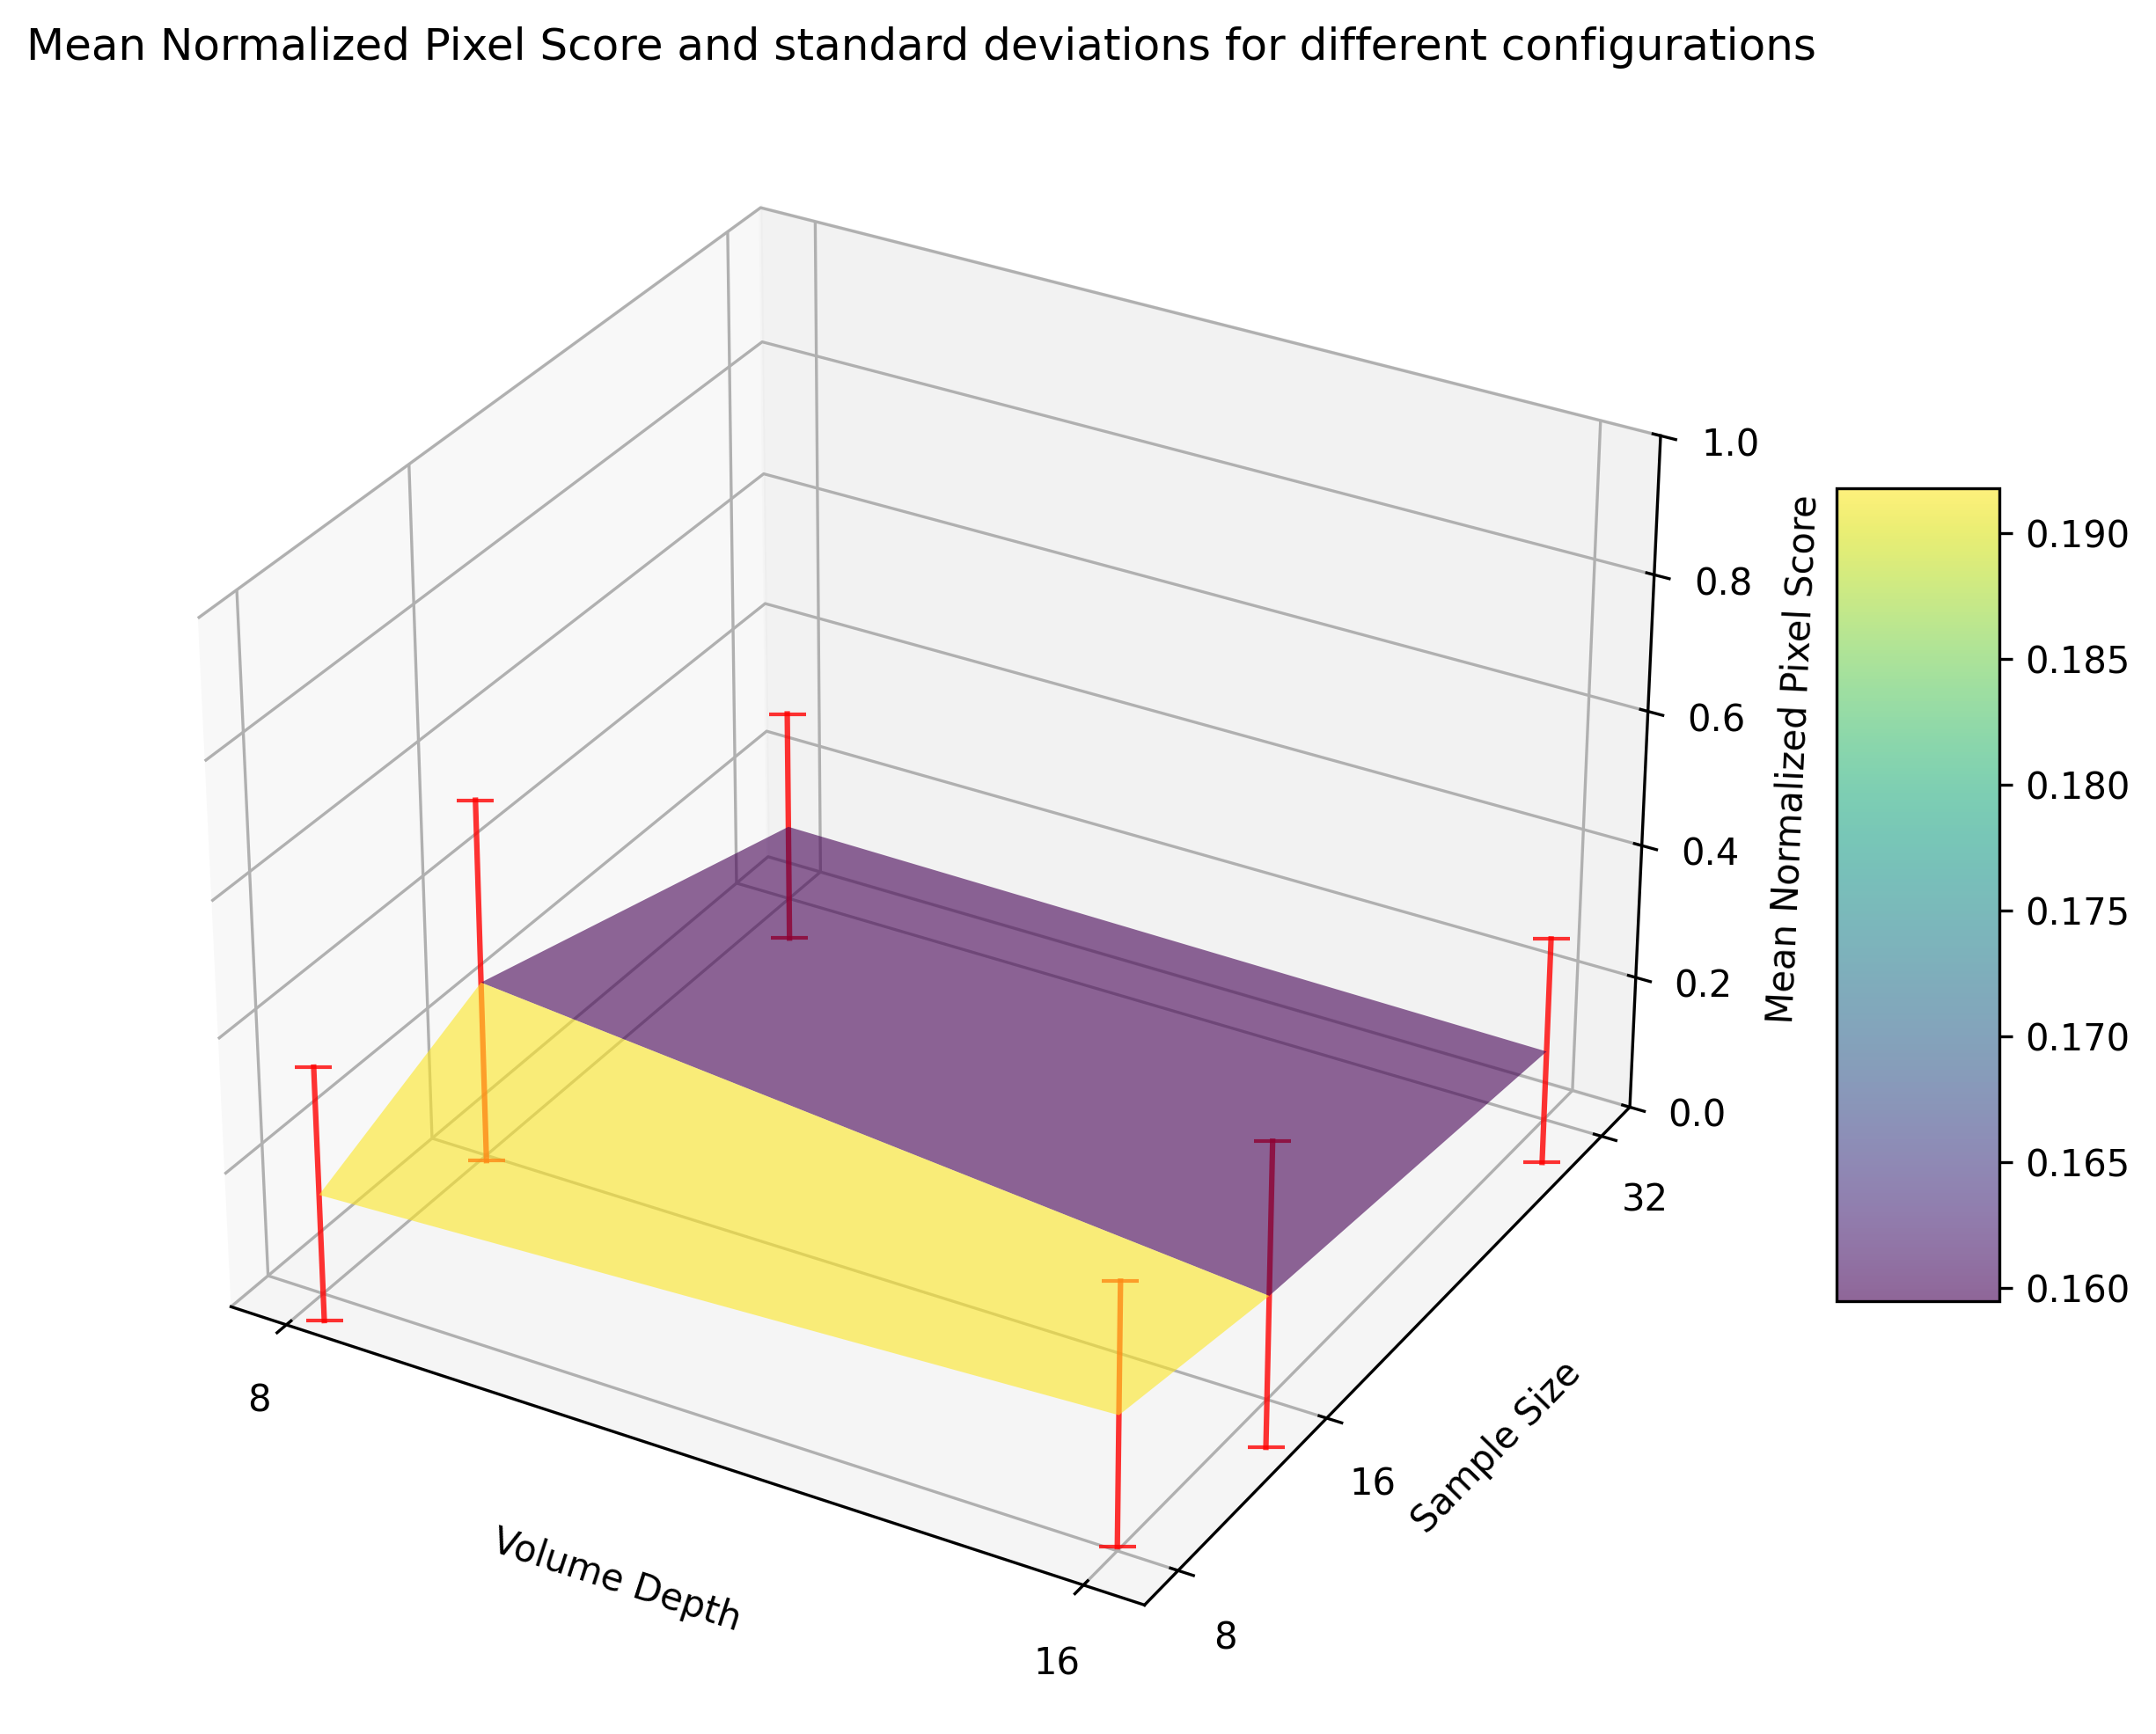

In [ ]:
#combine the two plots above into one 3d plot   
def plot_3d_surface(df, title):
    fig = plt.figure(figsize=(10,8),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    # create a meshgrid of sample_size and volume_depth
    sample_sizes = df["sample_size"].astype(int).unique()
    volume_depths = df["volume_depth"].astype(int).unique()
    X, Y = np.meshgrid(sample_sizes, volume_depths)
    # get the mean values for each combination of sample_size and volume_depth
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            sample_size = X[i, j]
            volume_depth = Y[i, j]
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            if len(mean_value) > 0:
                Z[i, j] = mean_value[0]
            else:
                Z[i, j] = np.nan
    # plot the surface
    surf = ax.plot_surface(Y, X, Z, cmap='viridis', edgecolor='none', alpha=0.6)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # calculate the std and add it as error bars to each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            sample_size = X[i, j]
            volume_depth = Y[i, j]
            std_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["std"].values
            mean_value = df[(df["sample_size"] == sample_size) & (df["volume_depth"] == volume_depth)]["mean"].values
            print(f"Sample Size: {sample_size}, Volume Depth: {volume_depth}, Mean: {mean_value}, Std: {std_value}")
            if len(std_value) > 0 and len(mean_value) > 0:
                ax.plot([volume_depth, volume_depth], [sample_size, sample_size], 
                        [mean_value[0] - std_value[0], mean_value[0] + std_value[0]], 
                        color='r', alpha=0.8, marker='_',markersize=10)
            

    ax.set_ylabel('Sample Size')
    ax.set_xlabel('Volume Depth')
    ax.set_zlabel('Mean Normalized Pixel Score')
    #set z limit to 0,1
    ax.set_zlim(0.0, 1)
    ax.set_xticks(volume_depths)
    ax.set_xticklabels(volume_depths)
    ax.set_yticks(sample_sizes)
    ax.set_yticklabels(sample_sizes)
    plt.title(f"Mean Normalized Pixel Score and standard deviations for different configurations")
    plt.show()

plot_3d_surface(df_run0,"Run 0")
#plot_3d_surface(df_run1,"Run 1")
#plot_3d_surface(df_run2,"Run 2")
#plot_3d_surface(df_run3,"Run 3")
#plot_3d_surface(df_run4,"Run 4")
### add a std bar to each point maybe


   sample_size  volume_depth  \
0            8             8   
2           16             8   
4           32             8   
1            8            16   
3           16            16   

                              normalized_pixel_score      mean       std  min  \
0  [0.0, 0.15625, 0.0, 0.0, 0.359375, 0.0, 0.0, 0...  0.149178  0.190317  0.0   
2  [0.0, 0.27734375, 0.76171875, 0.0078125, 0.074...  0.264194  0.272420  0.0   
4  [0.0, 0.0322265625, 0.0, 0.0, 0.0244140625, 0....  0.114027  0.177356  0.0   
1  [0.0, 0.09375, 0.0625, 0.171875, 0.0, 0.78125,...  0.198985  0.192802  0.0   
3  [0.31640625, 0.3671875, 0.0, 0.23828125, 0.457...  0.154710  0.226975  0.0   

        max  
0  0.890625  
2  0.941406  
4  0.876953  
1  0.921875  
3  0.937500  


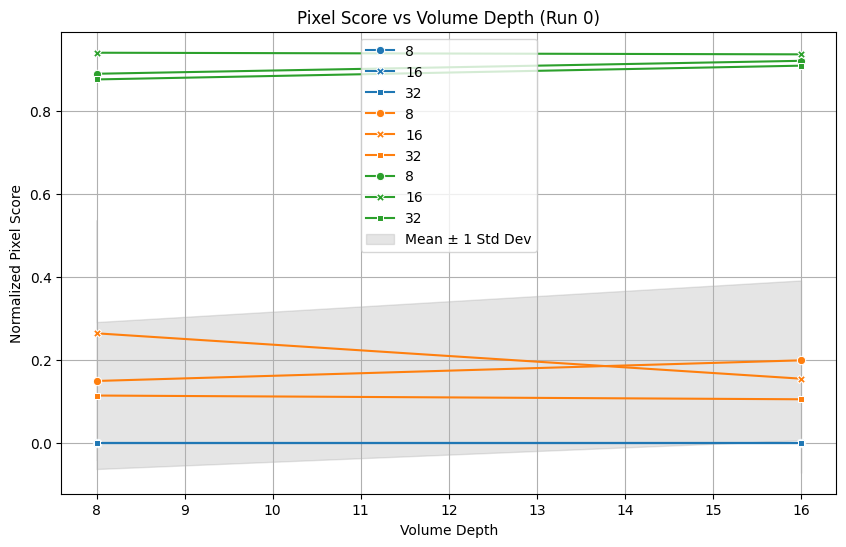

In [ ]:
#plot mean, min, max against volume_depth
import seaborn as sns
plt.figure(figsize=(10,6))
sample_sizes = df_run0["volume_depth"].astype(int).unique()
#plt.plot(sample_sizes, df_run0["mean"], label="Mean", marker='o')
#plt.fill_between(sample_sizes, df_run0["min"], df_run0["max"], color='gray', alpha=0.2, label="Min-Max Range")
#sort dfrun0 by sample_size
df_run0 = df_run0.sort_values(by="volume_depth")
print(df_run0.head())
sns.lineplot(x="volume_depth", y="min", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.lineplot(x="volume_depth", y="mean", data=df_run0, style="sample_size", markers=True, dashes=False)
sns.lineplot(x="volume_depth", y="max", data=df_run0, style="sample_size", markers=True, dashes=False)
#plot a channel around mean using std
plt.fill_between(df_run0["volume_depth"], df_run0["mean"] - df_run0["std"], df_run0["mean"] + df_run0["std"], color='gray', alpha=0.2, label="Mean ± 1 Std Dev")
plt.xlabel("Volume Depth")
plt.ylabel("Normalized Pixel Score")
plt.title("Pixel Score vs Volume Depth (Run 0)")
plt.legend()
plt.grid()
plt.show()


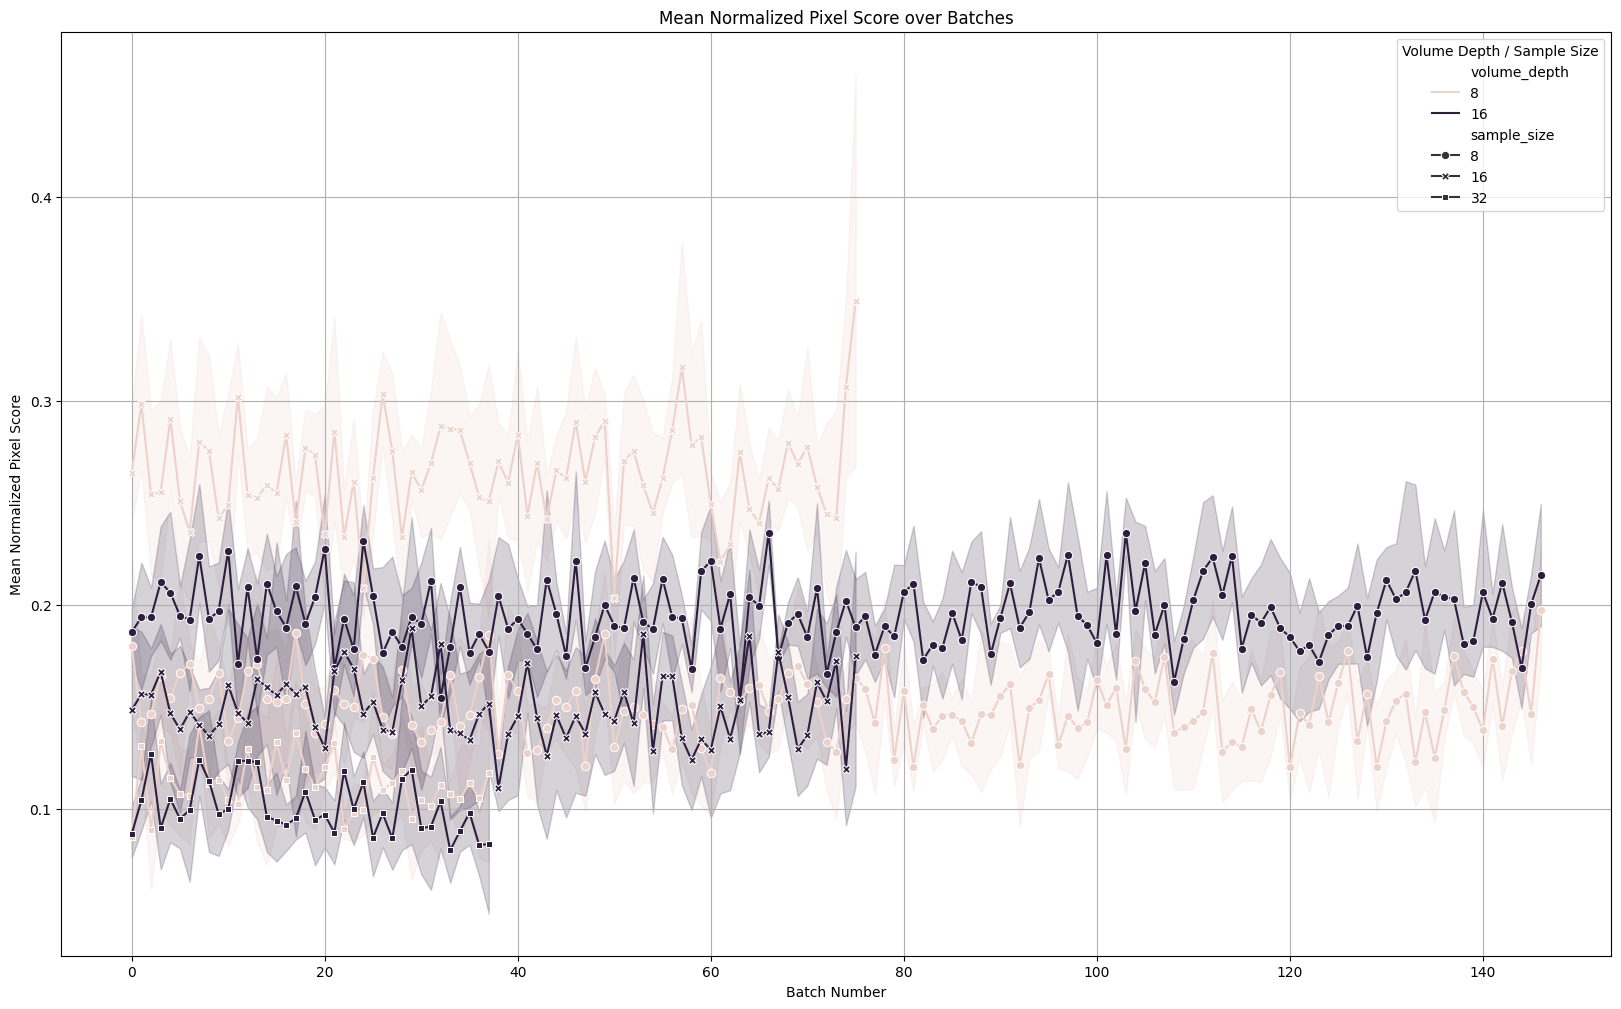

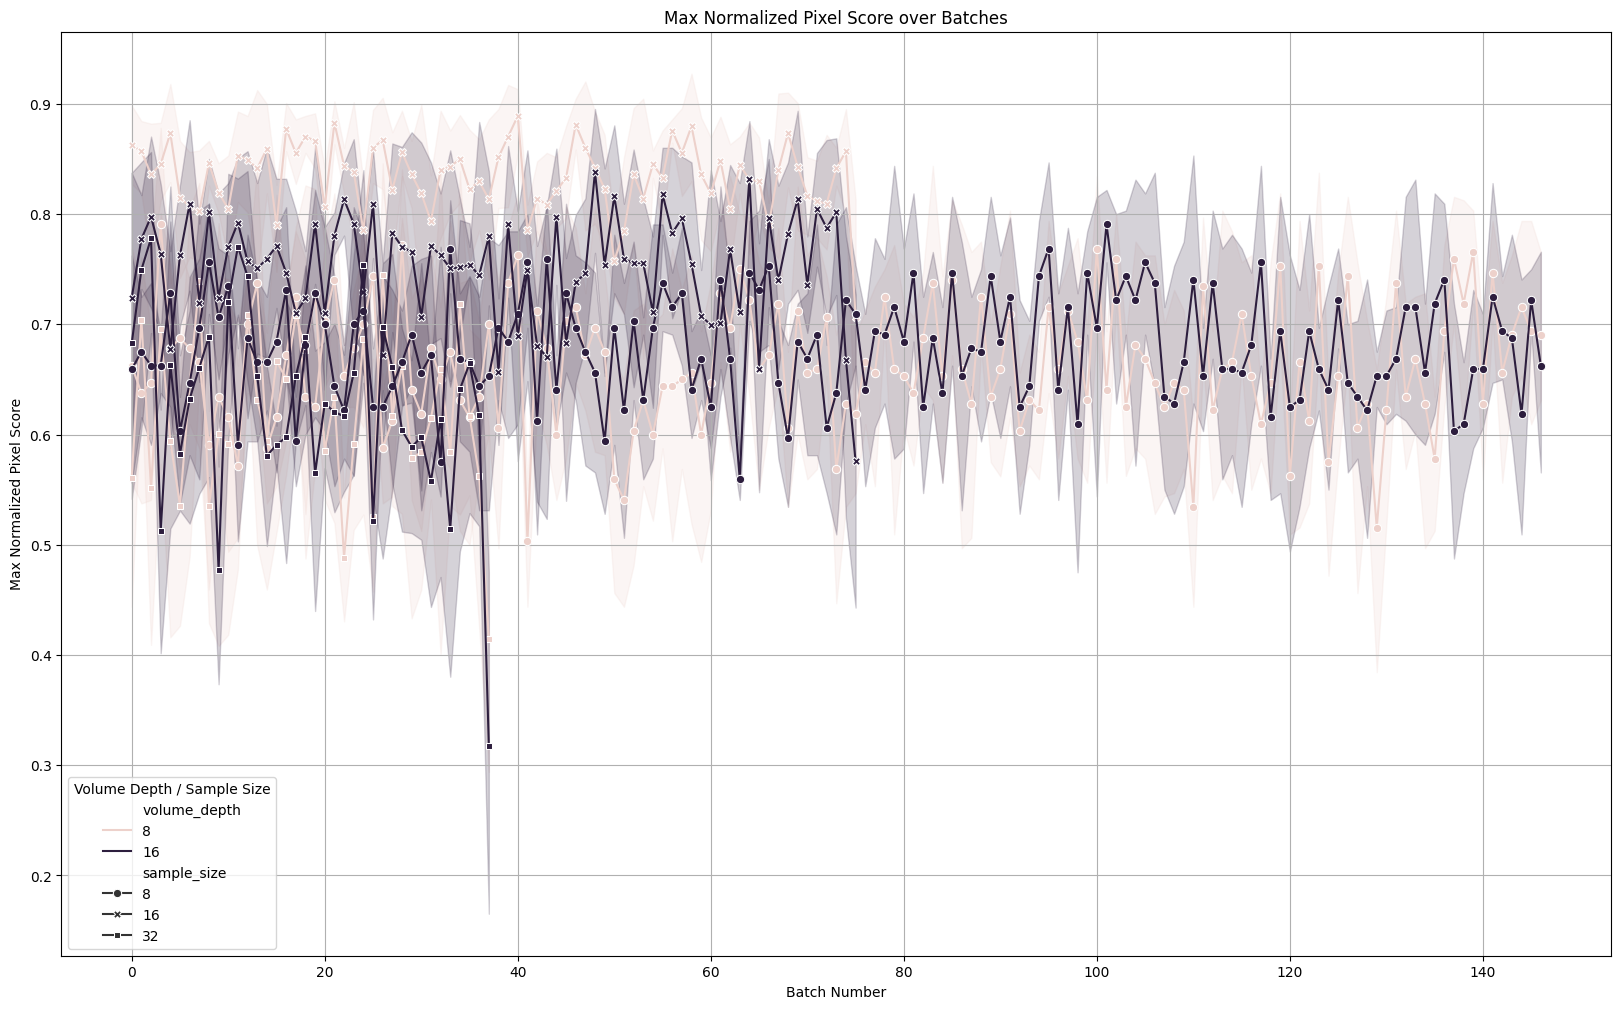

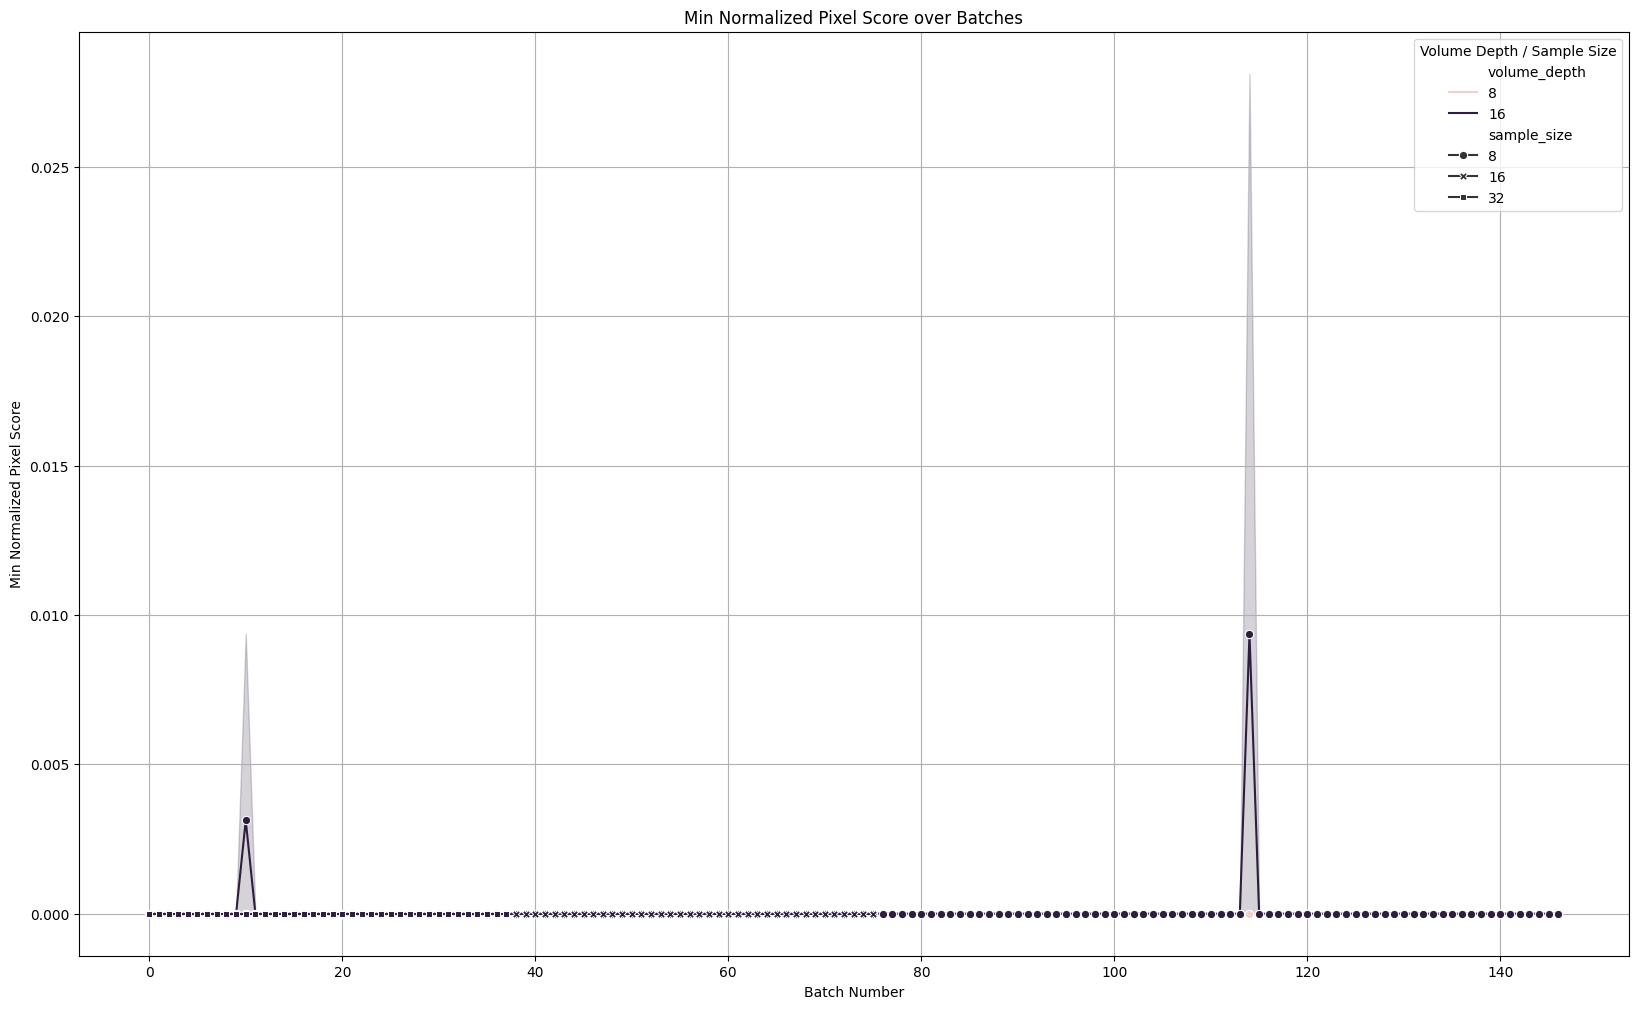

In [ ]:

#plot with seaborn lineplot with hue as volume_depth and style as sample_size
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="mean_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Mean Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Mean Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for max
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="max_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Max Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Max Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

#same for min
plt.figure(figsize=(20, 12))
sns.lineplot(data=df, x="batch_number", y="min_normalized_pixel_score", hue="volume_depth", style="sample_size", markers=True, dashes=False)
plt.title("Min Normalized Pixel Score over Batches")
plt.xlabel("Batch Number")
plt.ylabel("Min Normalized Pixel Score")
plt.legend(title="Volume Depth / Sample Size")
plt.grid()
plt.show()

/tmp/ipykernel_1198791/3752016141.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


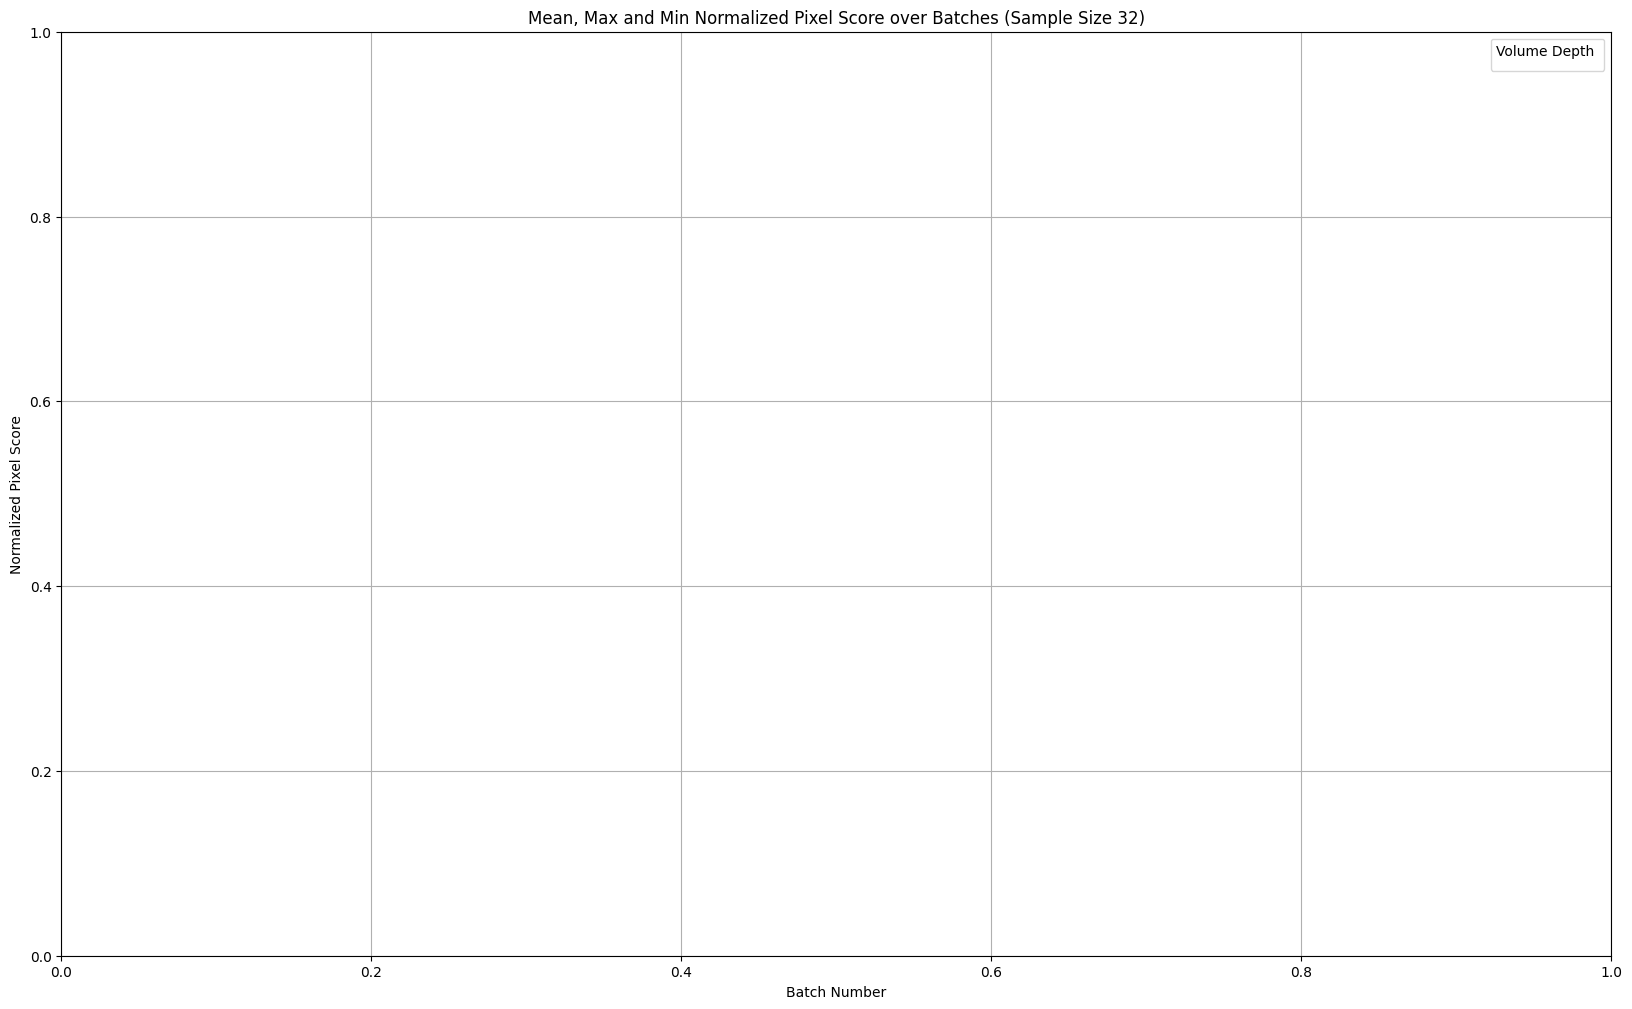

/tmp/ipykernel_1198791/3752016141.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


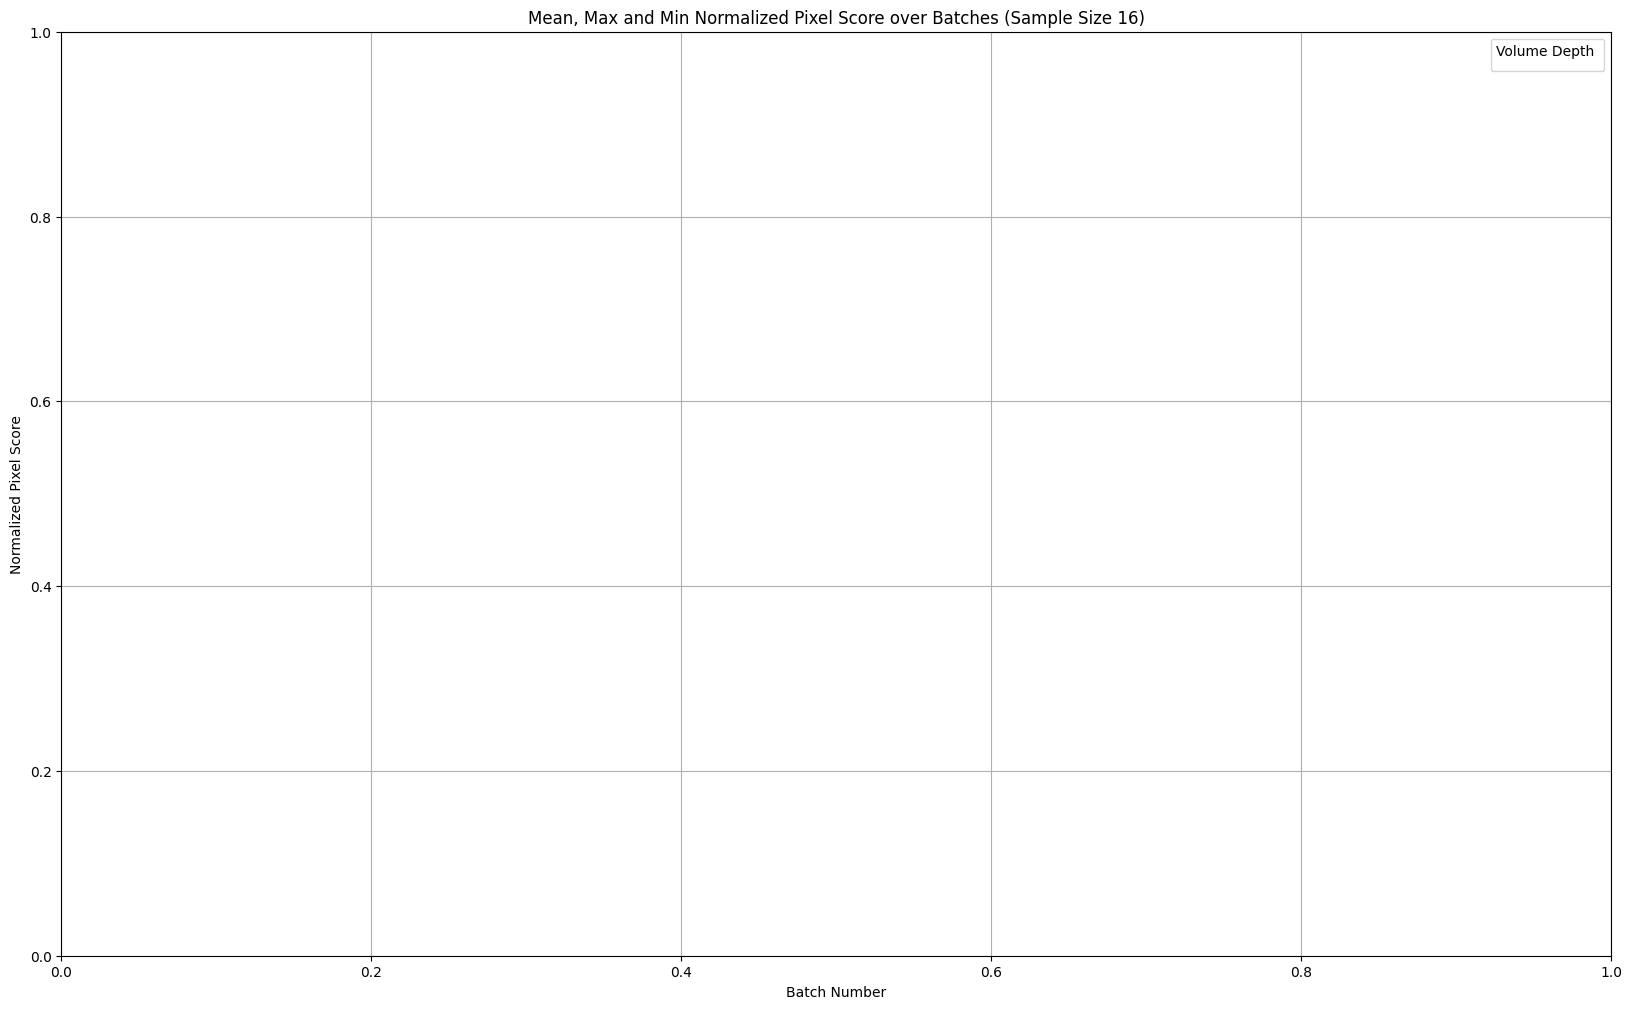

/tmp/ipykernel_1198791/3752016141.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Volume Depth ")


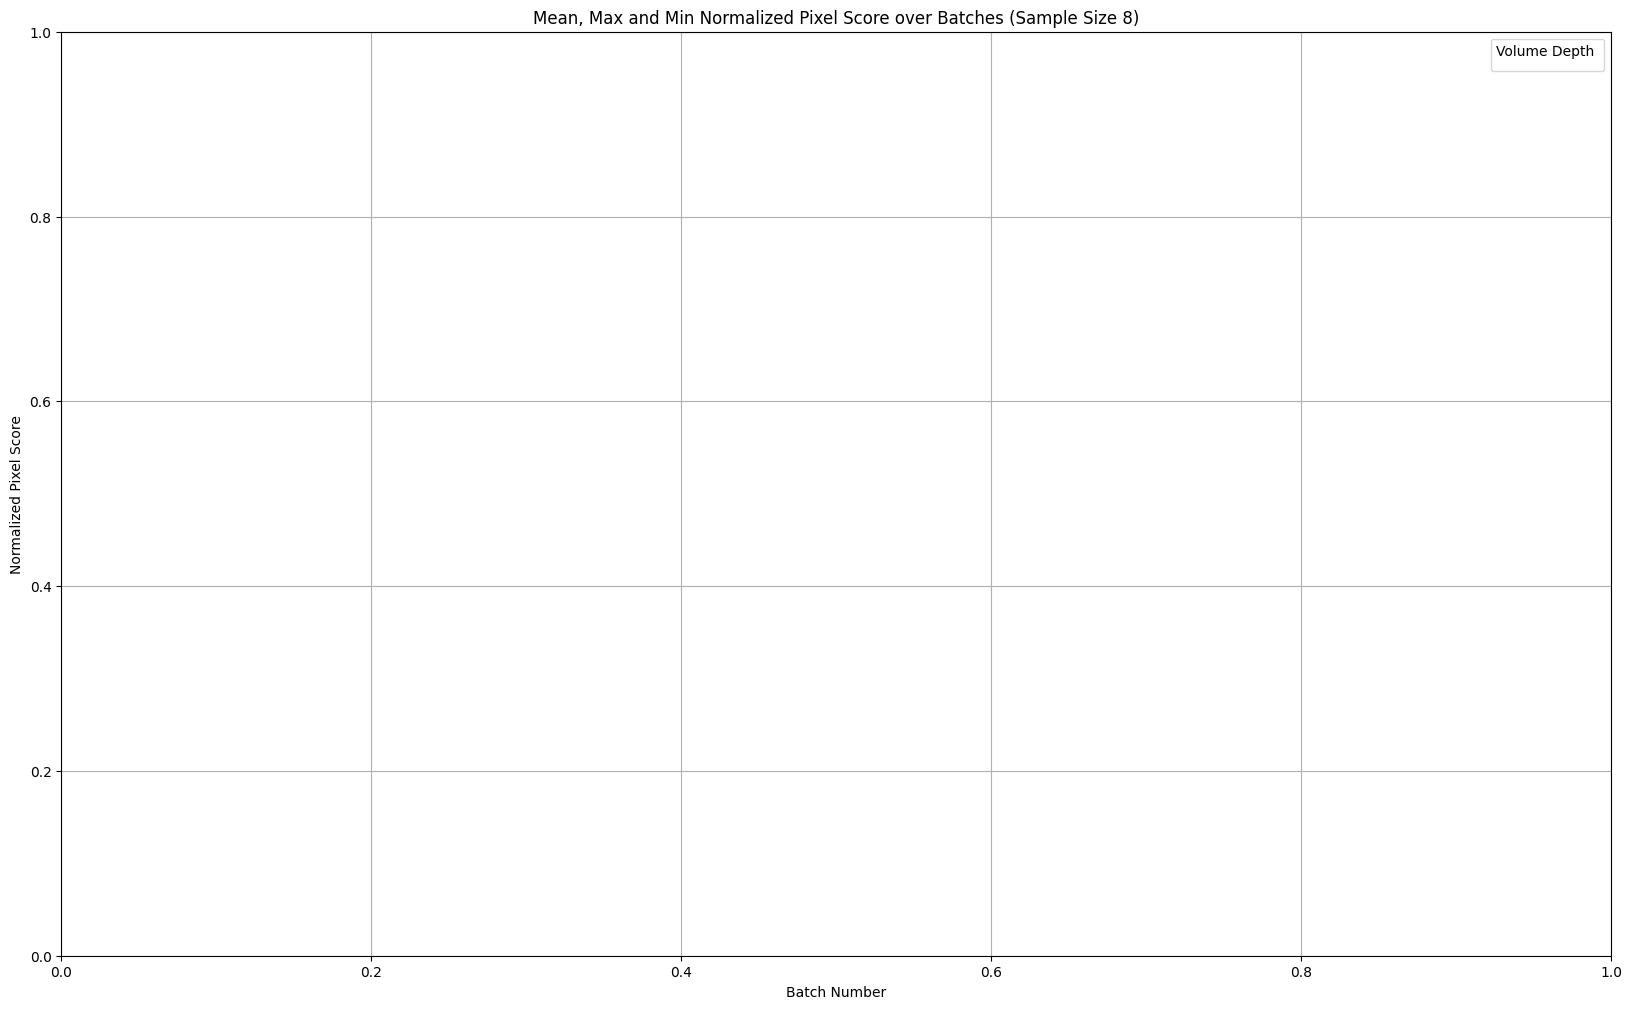

In [ ]:
# now mean,max and min only for sample_size 32 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="32"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 32)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

# now mean,max and min only for sample_size 16 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="16"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 16)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

# now mean,max and min only for sample_size 8 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="mean_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="max_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
sns.lineplot(data=df[df["sample_size"]=="8"], x="batch_number", y="min_normalized_pixel_score", style="volume_depth", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Sample Size 8)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Volume Depth ")
plt.grid()
plt.show()

/tmp/ipykernel_1198791/946882529.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


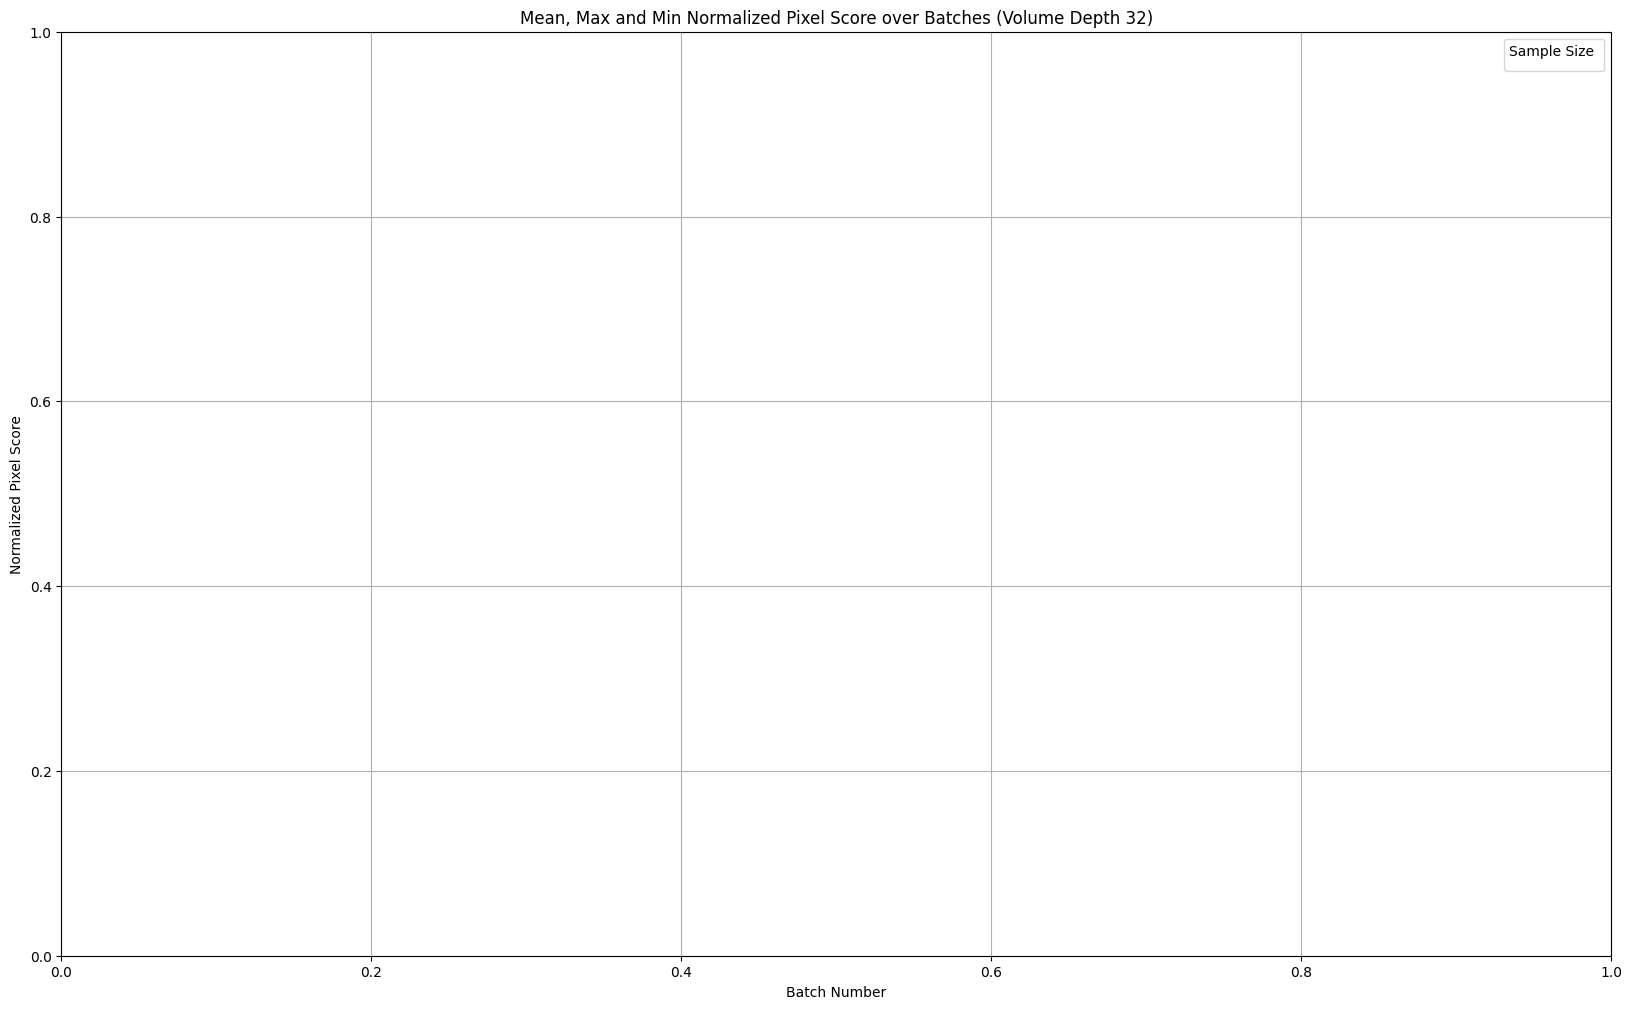

/tmp/ipykernel_1198791/946882529.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


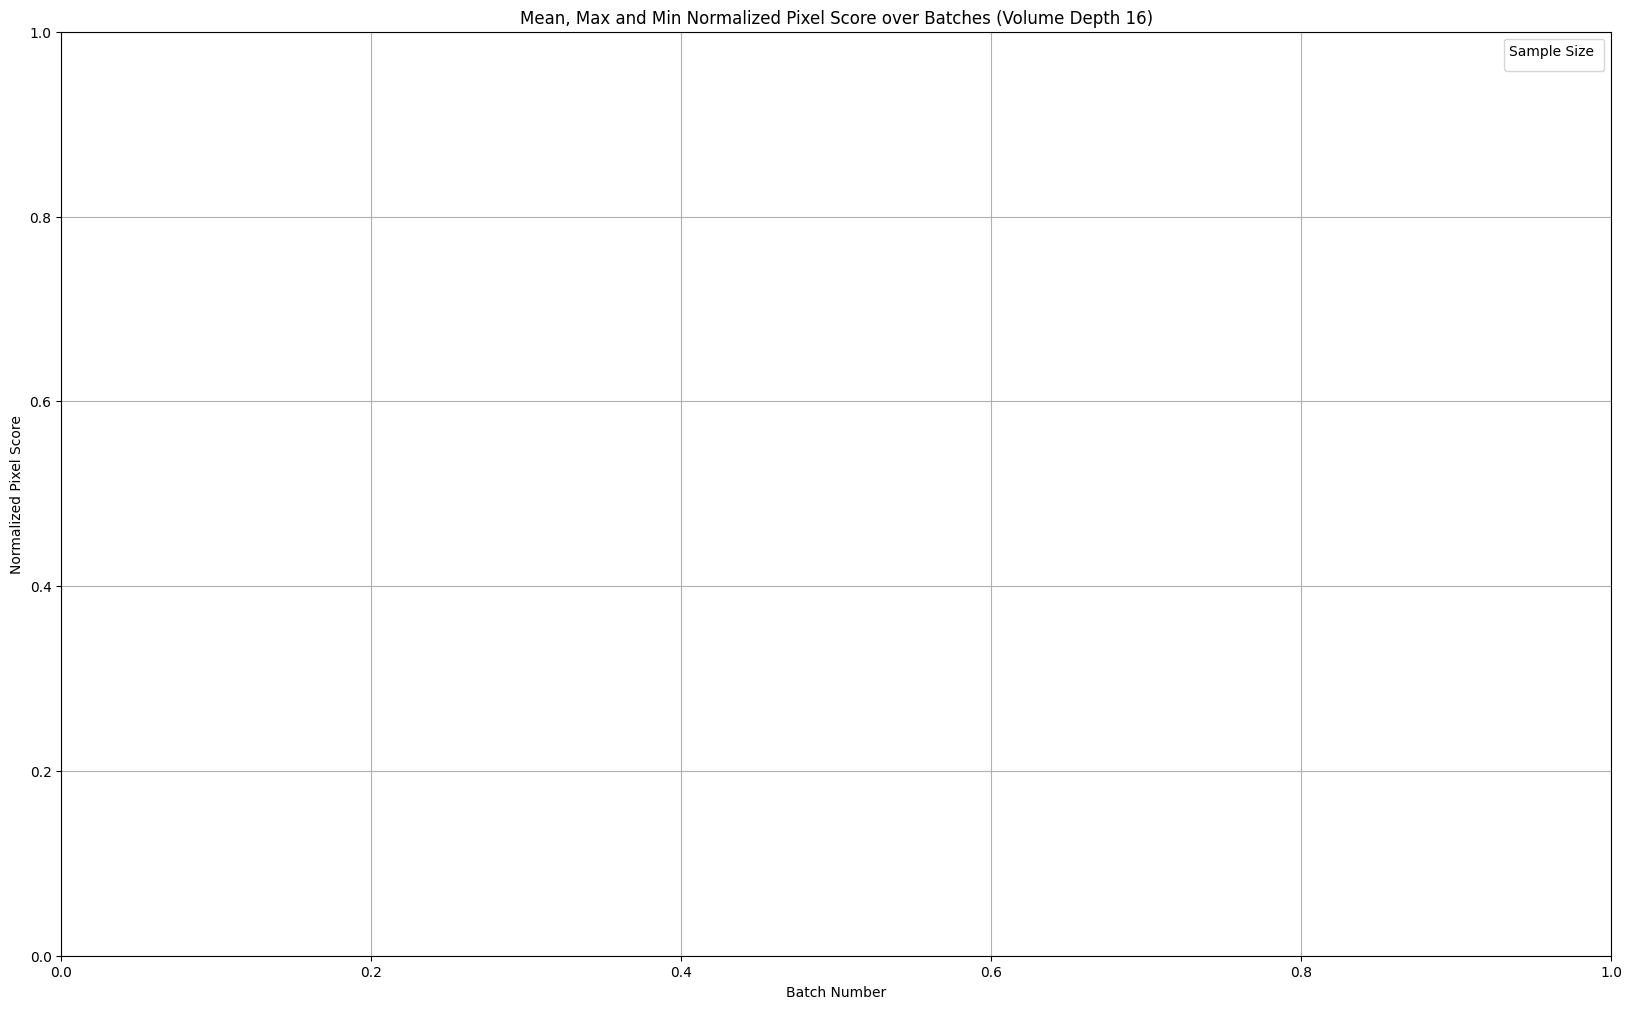

/tmp/ipykernel_1198791/946882529.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sample Size ")


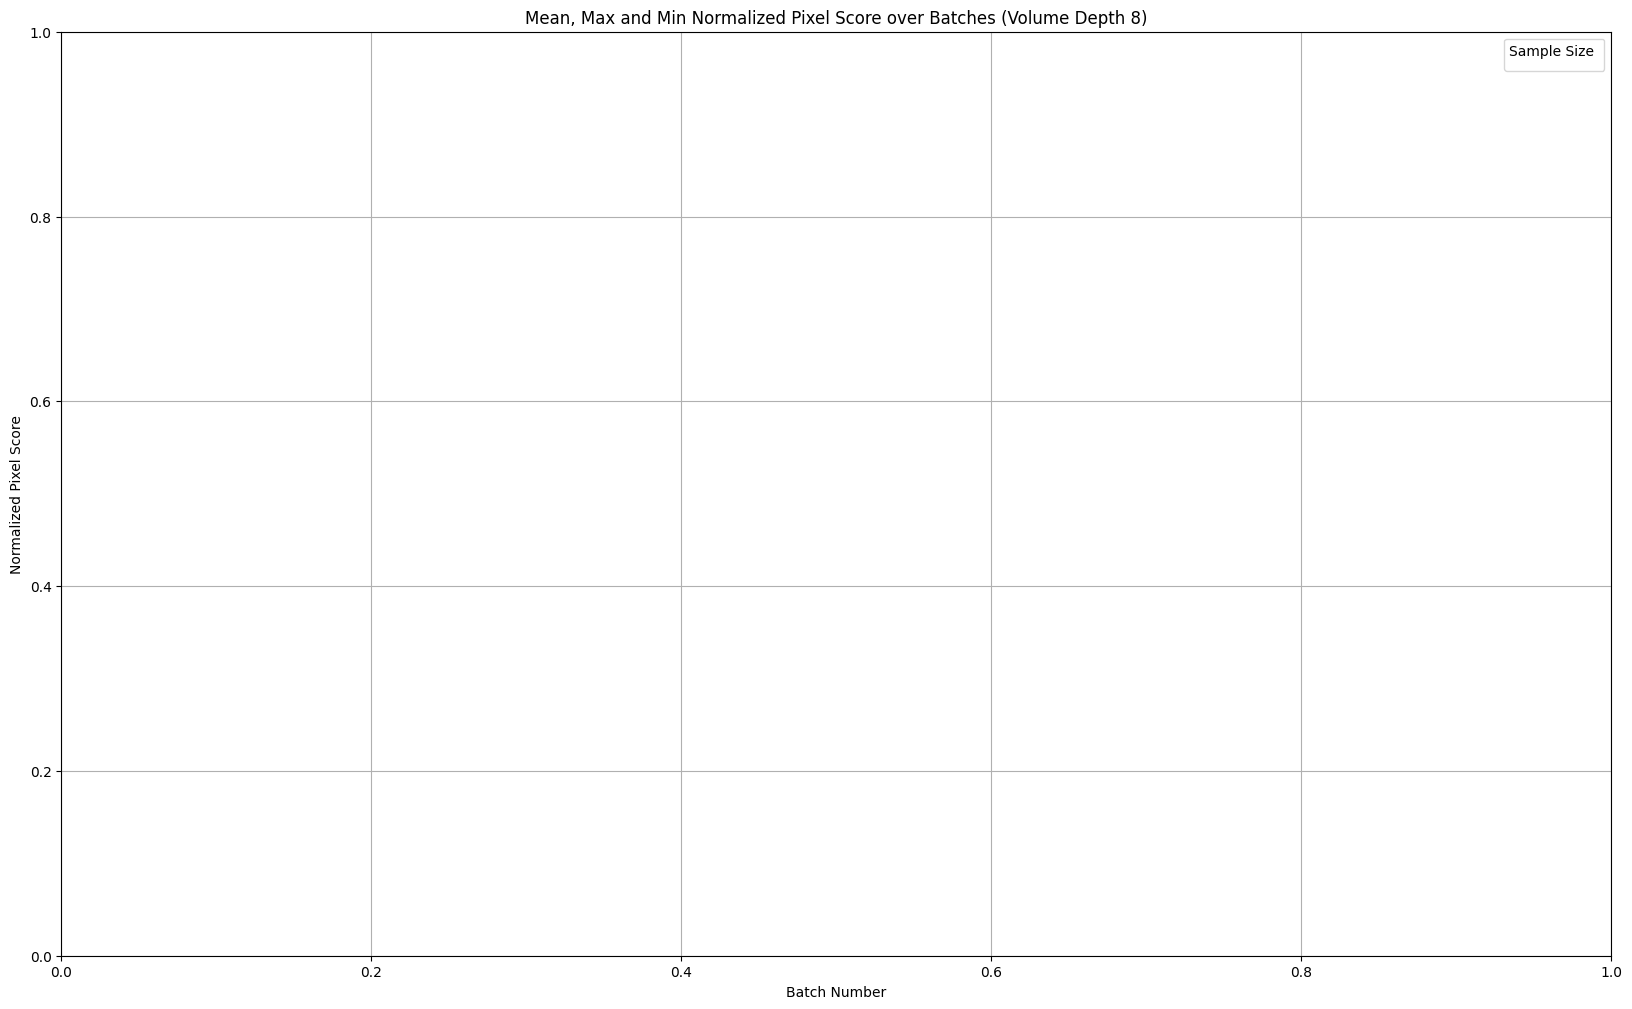

In [ ]:
# now mean,max and min only for volume_depth 32 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="32"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 32)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()

# now mean,max and min only for volume_depth 16 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="16"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 16)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()
# now mean,max and min only for volume_depth 8 in one plot with different hues for each
plt.figure(figsize=(20, 12))
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="mean_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="max_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
sns.lineplot(data=df[df["volume_depth"]=="8"], x="batch_number", y="min_normalized_pixel_score", style="sample_size", markers=True, dashes=False)
plt.title("Mean, Max and Min Normalized Pixel Score over Batches (Volume Depth 8)")
plt.xlabel("Batch Number")
plt.ylabel("Normalized Pixel Score")
plt.legend(title="Sample Size ")
plt.grid()
plt.show()